# Resolve Population and water use inconsistency 

In [1]:
import os, sys
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import configparser
import geopandas
from ipyleaflet import Map, GeoData, basemaps, LayersControl
import contextily as cx
%matplotlib widget
%matplotlib inline
%matplotlib ipympl

In [3]:
config = configparser.ConfigParser()
config_file = r"C:\work\water_use\ml_experiments\annual_v_0_0\config_file.ini"
config.read(config_file)

db_root = r"C:\work\water_use\mldataset"


# get variable names
workspace = config.get("Files", "Workspace")
train_file = config.get("Files", "Train_file")
target = config.get("Target", "target_field")

#read files
df_main = pd.read_csv(train_file)
df_train = df_main[df_main['wu_rate'] > 0]

# also load pop_info
pop_info = pd.read_csv(r"C:\work\water_use\mldataset\ml\training\train_datasets\Annual\pop_and_others.csv")

# load new swud wu info
swud_df16 = pd.read_csv(os.path.join(db_root, r"ml\training\targets\monthly_annually\SWUDS v16 WDs by FROM-sites and by WSA_AGG_ID_04282021.csv"), 
                        encoding='cp1252')

C:\anaconda\envs\ml\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (12,20,65,66) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
pop_info['pc_tract'] = pop_info['wu_rate']/pop_info['tract_pop']
pop_info['pc_plc'] = pop_info['wu_rate']/pop_info['plc_pop_interpolated']
pop_info['pc_tpop'] = pop_info['wu_rate']/pop_info['tpop_srv']

pop_info['pz_tract'] = pop_info['tract_pop']/pop_info['zillow_nh']
pop_info['pz_plc'] =  pop_info['plc_pop_interpolated']/pop_info['zillow_nh']
pop_info['pz_tpop'] =  pop_info['tpop_srv']/pop_info['zillow_nh']

pop_info['pf_tract'] = pop_info['tract_pop']/pop_info['bdg_ftp_count']
pop_info['pf_plc'] =  pop_info['plc_pop_interpolated']/pop_info['bdg_ftp_count']
pop_info['pf_tpop'] =  pop_info['tpop_srv']/pop_info['bdg_ftp_count']


In [5]:
pc_columns = [c for c in pop_info.columns if ("pc_" in c or "pz_" in c or "pf_" in c)]
for c in pc_columns:
    pop_info[c] =  np.log10(pop_info[c])
pop_info.replace([np.inf, -np.inf], np.nan, inplace=True)




C:\anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
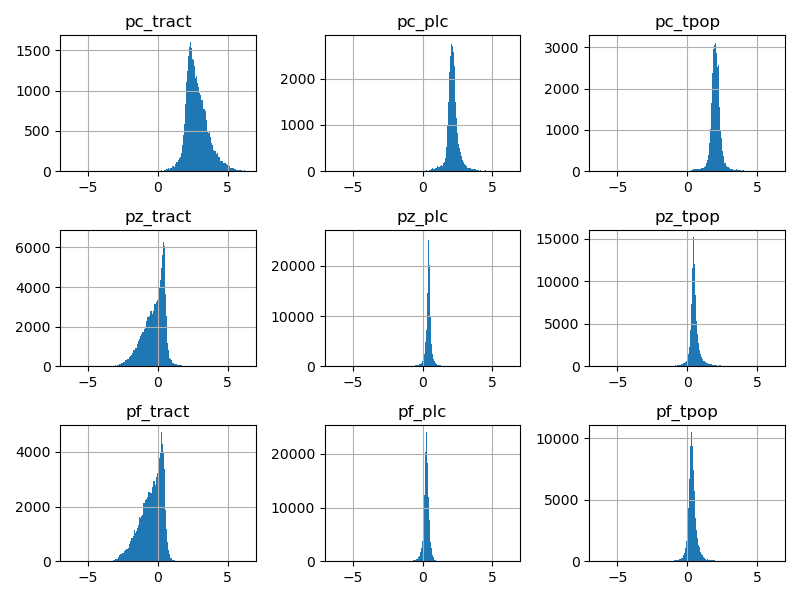

In [5]:
f, axs = plt.subplots(3,3,figsize=(8, 6))
col_iter = iter(pc_columns)
for ax in axs.reshape(-1): 
    curr_col = next(col_iter)
    pop_info[curr_col].hist(ax = ax, bins = 500);
    ax.set_title(curr_col)
    ax.set_xlim([-7,7])
plt.tight_layout()

In [6]:
df_pc = pop_info[pc_columns]
np.power(10, df_pc).describe()

,pc_tract,pc_plc,pc_tpop,pz_tract,pz_plc,pz_tpop,pf_tract,pf_plc,pf_tpop
count,7.573700e+04,5.659100e+04,7.573200e+04,384090.000000,3.030390e+05,384027.000000,393225.000000,3.036430e+05,393141.000000
mean,4.375918e+06,3.694258e+08,7.483017e+04,33.887285,4.584790e+01,77.866084,1.353407,2.397704e+00,4.937056
std,1.195000e+09,8.786477e+10,2.050160e+07,2778.161165,3.112064e+03,5818.598165,34.716376,3.130214e+01,88.727707
min,1.308168e-04,2.502542e-04,4.156407e-05,0.000110,1.087204e-07,0.002443,0.000027,6.452352e-12,0.002392
25%,1.803745e+02,9.011705e+01,6.945284e+01,0.169385,2.200103e+00,2.291082,0.101895,1.440989e+00,1.550736
50%,4.563238e+02,1.369101e+02,1.049801e+02,0.778440,2.701632e+00,2.988113,0.480191,1.862982e+00,2.150315
75%,1.740210e+03,2.172564e+02,1.654141e+02,2.154558,3.285246e+00,4.287663,1.538032,2.362339e+00,3.115826
max,3.288675e+11,2.090203e+13,5.641928e+09,331410.202800,3.349572e+05,609841.758423,6744.971175,4.006208e+03,18594.686910


Text(0.5, 1.0, 'Per Capita Water Use')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
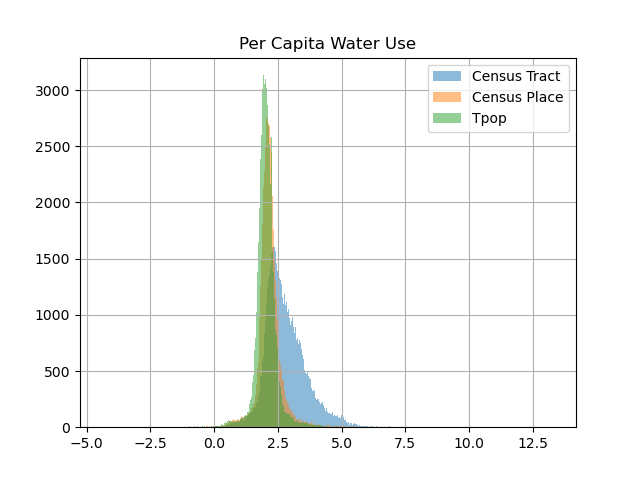

In [7]:
plt.figure()
pop_info['pc_tract'].hist(bins = 500, alpha = 0.5, label = 'Census Tract');
pop_info['pc_plc'].hist( bins = 500, alpha = 0.5, label = 'Census Place');
pop_info['pc_tpop'].hist(bins = 500, alpha = 0.5, label = 'Tpop');
plt.legend()
plt.title("Per Capita Water Use")


Text(0.5, 1.0, 'People per building')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
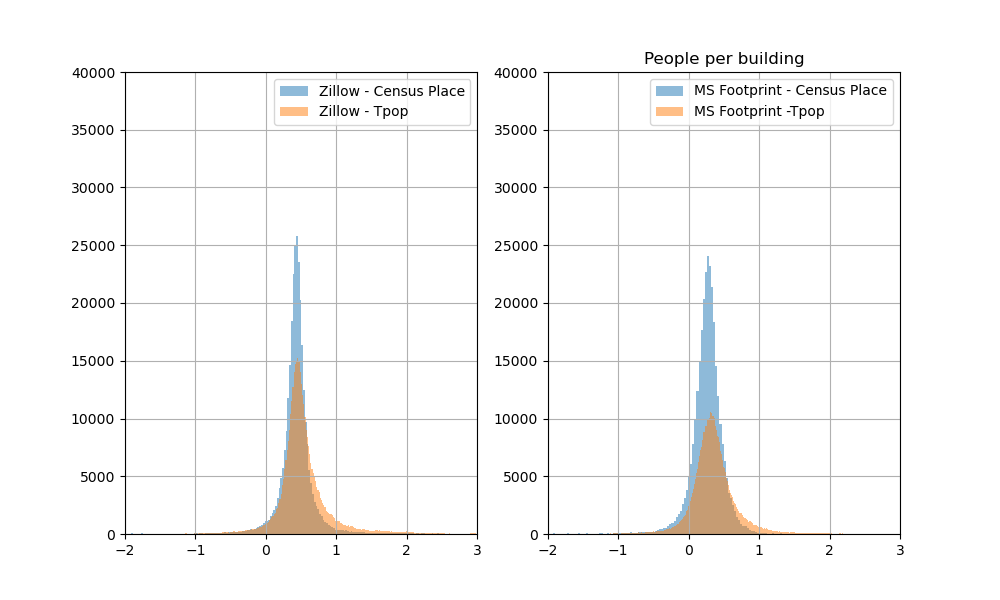

In [8]:
f, axs = plt.subplots(1,2,figsize=(10, 6))

pop_info['pz_plc'].hist(ax = axs[0],  bins = 500, alpha = 0.5, label = 'Zillow - Census Place');
pop_info['pz_tpop'].hist(ax = axs[0], bins = 500, alpha = 0.5, label = 'Zillow - Tpop');
axs[0].legend()
axs[0].set_xlim([-2,3])
axs[0].set_ylim([0,40000])
pop_info['pf_plc'].hist( ax = axs[1], bins = 500, alpha = 0.5, label = 'MS Footprint - Census Place');
pop_info['pf_tpop'].hist(ax = axs[1],bins = 500, alpha = 0.5, label = 'MS Footprint -Tpop');
axs[1].set_xlim([-2,3])
axs[1].set_ylim([0,40000])
plt.legend()
plt.title("People per building")

C:\Users\AALZRA~1\AppData\Local\Temp\2/ipykernel_33440/594289619.py:8: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim([0,6])


(1.303452743713862, 6)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
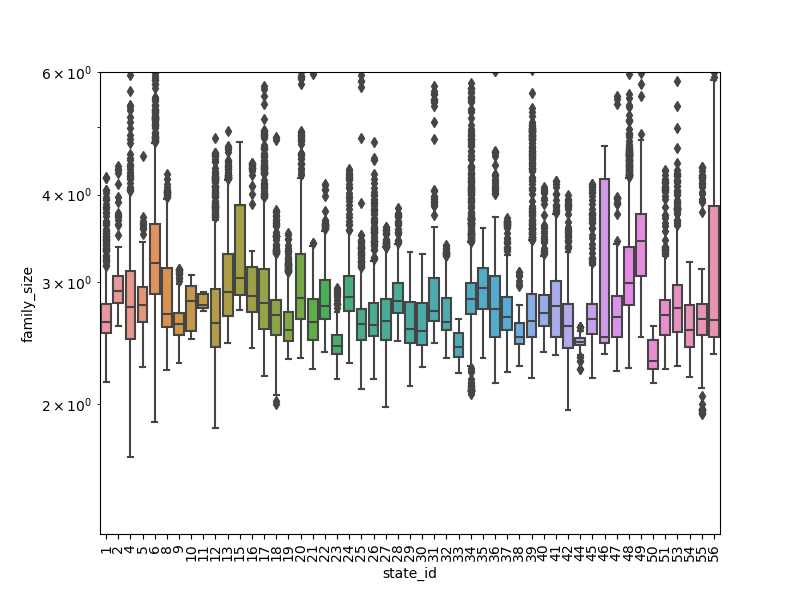

In [9]:
var = 'state_id'
f, ax = plt.subplots(figsize=(8, 6))
df_main['family_size'] = df_main['population']/df_main['households2']
df__ = df_main[df_main['population']>15000]
fig = sns.boxplot(x=var, y='family_size', data=df__)
ax.set_yscale('log');
plt.xticks(rotation=90);
ax.set_ylim([0,6])


# Typical Per_capita water use

In [10]:
from shapely.geometry import Point, Polygon
pc_xy_tpop = pd.read_csv(r"C:\work\water_use\mldataset\ml\training\misc_features\spatial_features\pc_50_tpopsrv.csv")
pc_xy_tpop_old = pd.read_csv(r"C:\work\water_use\mldataset\ml\training\misc_features\spatial_features\pc_50.csv")

pc_xy_tpop = geopandas.GeoDataFrame(
    pc_xy_tpop, geometry=geopandas.points_from_xy(pc_xy_tpop.x, pc_xy_tpop.y), crs = "EPSG:5070")
pc_xy_tpop = pc_xy_tpop.to_crs(epsg=4326)

In [11]:
geo_data = GeoData(geo_dataframe = pc_xy_tpop,  style={'color': 'black', 'radius':8, 'fillColor': '#3366cc', 'opacity':0.5, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
    hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
    point_style={'radius': 1, 'color': 'red', 'fillOpacity': 0.8, 'fillColor': 'blue', 'weight': 3},
    name = 'Release')

In [12]:

m = Map(center=(40,-100), zoom = 3, basemap= basemaps.OpenStreetMap)
#m.add_layer(geo_data)
m

Map(center=[40, -100], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

<AxesSubplot:>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
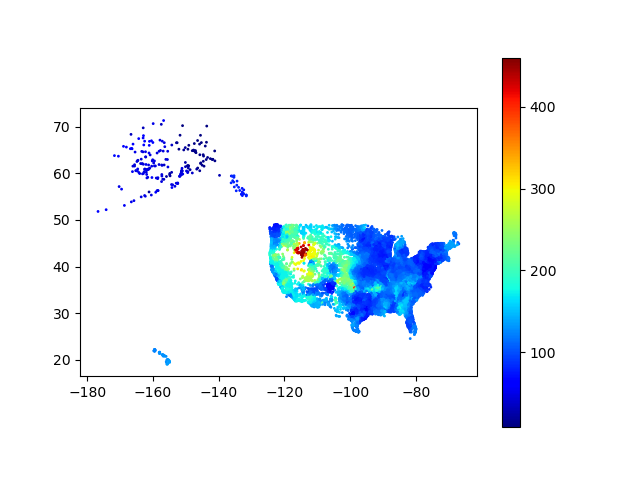

In [13]:
pc_xy_tpop.plot(column = 'pc_median', markersize = 1,  cmap='jet', legend=True)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
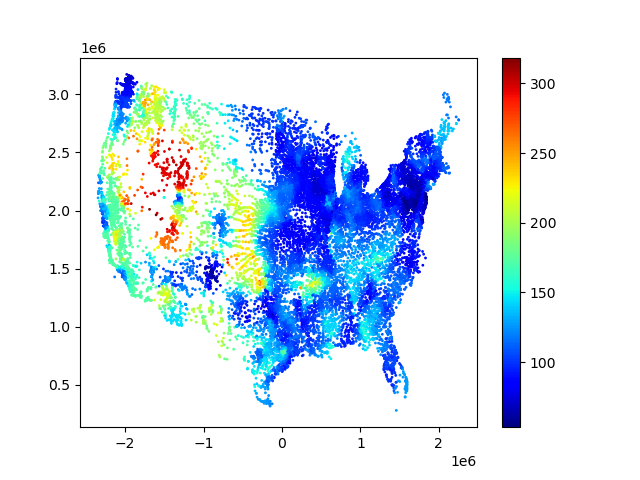

In [14]:
plt.figure()
plt.scatter(pc_xy_tpop_old['x'], pc_xy_tpop_old['y'], c = pc_xy_tpop_old['pc_median'], s = 1, cmap = 'jet')
plt.colorbar()
pc_xy_tpop =pc_xy_tpop_old

In [15]:
# merge per capita map with pop_info layer
pop_info = pop_info.merge(pc_xy_tpop[['sys_id', 'x', 'y','pc_median']], how = 'left', right_on='sys_id', left_on='sys_id')

In [16]:
pop_info

,Unnamed: 0,year,pop,tract_pop,cdc_pop_0,plc_pop_interpolated,tpop_srv,zillow_nh,bdg_ftp_count,wu_rate,...,pc_tpop,pz_tract,pz_plc,pz_tpop,pf_tract,pf_plc,pf_tpop,x,y,pc_median
0,0,2000,0,740.290388,19.927953,1106.956079,1018.761995,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.332979e+06,3.993921e+06,NaN
1,1,2001,0,762.662365,102.304079,1101.857372,1049.549534,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.332979e+06,3.993921e+06,NaN
2,2,2002,0,785.034341,184.680512,1096.758665,1080.337073,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.332979e+06,3.993921e+06,NaN
3,3,2003,0,807.406317,267.056946,1091.659958,1111.124612,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.332979e+06,3.993921e+06,NaN
4,4,2004,0,829.778293,349.433688,1086.561252,1141.912151,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.332979e+06,3.993921e+06,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401578,16,2016,0,0.371218,0.371218,109.138817,306.443367,NaN,186.0,NaN,...,NaN,NaN,NaN,NaN,-2.699884,-0.231534,0.216837,-1.152801e+06,2.532047e+06,280.833541
401579,17,2017,0,0.379047,0.379047,56.552770,312.906292,NaN,186.0,NaN,...,NaN,NaN,NaN,NaN,-2.690820,-0.517059,0.225901,-1.152801e+06,2.532047e+06,280.833541
401580,18,2018,0,0.387101,0.387101,50.463745,319.555460,NaN,186.0,NaN,...,NaN,NaN,NaN,NaN,-2.681688,-0.566533,0.235033,-1.152801e+06,2.532047e+06,280.833541
401581,19,2019,0,0.388307,0.388307,48.391644,320.550702,NaN,186.0,NaN,...,NaN,NaN,NaN,NaN,-2.680338,-0.584743,0.236384,-1.152801e+06,2.532047e+06,280.833541


In [17]:
pop_info['diff_pc_tract'] = np.log10(np.abs(np.power(10, pop_info['pc_tract']) - pop_info['pc_median']))
pop_info['diff_pc_plc'] =  np.log10(np.abs(np.power(10, pop_info['pc_plc'])  - pop_info['pc_median']))
pop_info['diff_pc_tpop'] = np.log10(np.abs(np.power(10, pop_info['pc_tpop'])  - pop_info['pc_median']))

pop_info['diff_pz_tract'] = np.log10(np.abs(np.power(10, pop_info['pz_tract']) - 2.75))
pop_info['diff_pz_plc'] =  np.log10(np.abs(np.power(10, pop_info['pz_plc'])  - 2.75))
pop_info['diff_pz_tpop'] = np.log10(np.abs(np.power(10, pop_info['pz_tpop'])  - 2.75))

pop_info['diff_pf_tract'] = np.log10(np.abs(np.power(10, pop_info['pf_tract']) - 2.15))
pop_info['diff_pf_plc'] =  np.log10(np.abs(np.power(10, pop_info['pf_plc'])  - 2.15))
pop_info['diff_pf_tpop'] = np.log10(np.abs(np.power(10, pop_info['pf_tpop'])  - 2.15))

pop_info.replace([np.inf, -np.inf], np.nan, inplace=True)

C:\anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
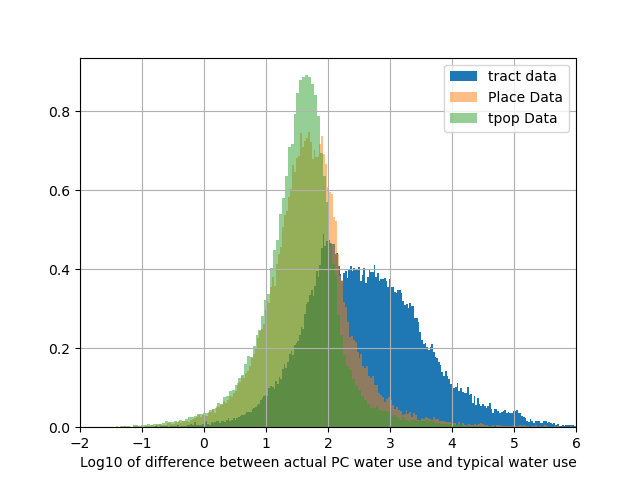

In [18]:
plt.figure()
pop_info['diff_pc_tract'].hist(bins = 500, density=True, label = 'tract data')
pop_info['diff_pc_plc'].hist(bins = 500, alpha = 0.5, density=True, label = 'Place Data')
pop_info['diff_pc_tpop'].hist(bins = 500, alpha = 0.5, density=True, label = 'tpop Data')
plt.xlim([-2,6])
plt.xlabel("Log10 of difference between actual PC water use and typical water use")
plt.legend()

In [19]:
# find best population
diff_pc = ['diff_pc_tract', 'diff_pc_plc', 'diff_pc_tpop']
diff_pz = ['diff_pz_tract', 'diff_pz_plc', 'diff_pz_tpop']
diff_pf = ['diff_pf_tract', 'diff_pf_plc', 'diff_pf_tpop']

pop_info['pop'] = 0
# systems with water use
best_pop_col = pop_info[diff_pc].idxmin(axis=1)
pop_pc_map = {'diff_pc_tract':'tract_pop', 'diff_pc_plc':'plc_pop_interpolated', 'diff_pc_tpop':'tpop_srv'}
for f in ['diff_pc_tract', 'diff_pc_plc', 'diff_pc_tpop']:
    mask = best_pop_col == f
    pp_field = pop_pc_map[f]
    curr_syss = pop_info[mask]['sys_id'].unique()
    mask2 = pop_info['sys_id'].isin(curr_syss)
    pop_info.loc[mask2, 'pop'] = pop_info.loc[mask2, pp_field]
    

Text(0, 0.5, 'Water use')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
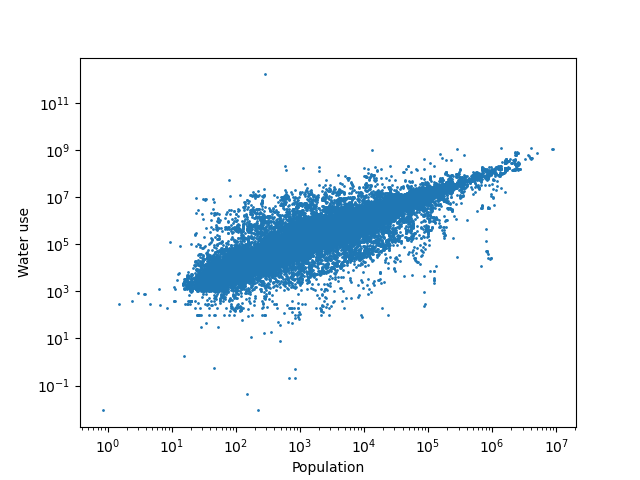

In [20]:
plt.figure()
plt.scatter(pop_info['pop'], pop_info['wu_rate'], s = 1)
#plt.plot(pop_info['pop'], 100*pop_info['pop'], c= 'r')
plt.yscale('log'); plt.xscale('log')
plt.xlabel('Population')
plt.ylabel('Water use')


## Percent of systems without WU data

In [21]:
#  a list of bad(??) population by comparing tpop and tract pop??

In [22]:
np.sum(pop_info['pop']>0)/len(pop_info)

0.7962662762118914

<AxesSubplot:>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
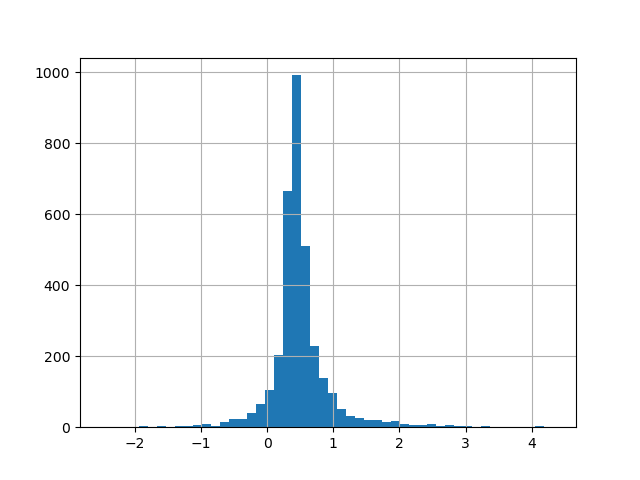

In [23]:
mask_2019 = (pop_info['pop']==0) & (pop_info['year']== 2019)
pop2019 = pop_info[mask_2019]
plt.figure()
pop2019['pz_tpop'].hist(bins = 50)


In [24]:
pz95 = pop_info['pz_plc'].quantile(0.95)
pz05 = pop_info['pz_plc'].quantile(0.05)
pf95 = pop_info['pf_plc'].quantile(0.95)
pf05 = pop_info['pf_plc'].quantile(0.05)
hpop = pop2019[(pop2019['pz_tpop']>=pz95) & (pop2019['pz_plc']>=pz95)] 
lpop = pop2019[(pop2019['pz_tpop']<=pz05) & (pop2019['pz_plc']<=pz05)]
s1 = set(hpop['sys_id'].values).union(lpop['sys_id'].values)

hpop = pop2019[(pop2019['pf_tpop']>=pf95) & (pop2019['pf_plc']>=pf95)] 
lpop = pop2019[(pop2019['pf_tpop']<=pf05) & (pop2019['pf_plc']<=pf05)]
s2 = set(hpop['sys_id'].values).union(lpop['sys_id'].values)

house_count_off_sys = s1.intersection(s2)

In [25]:
mask = (pop_info['sys_id'].isin(house_count_off_sys)) & (pop_info['bdg_ftp_count']>0)
person_per_building = 10**pop_info['pf_plc'].quantile(0.5)
pop_info.loc[mask, 'pop'] = pop_info.loc[mask, 'bdg_ftp_count'] * person_per_building

In [26]:
pop_info.loc[mask, 'pop'] 

147       639.002995
148       639.002995
149       639.002995
150       639.002995
151       639.002995
             ...    
377050    886.779667
377051    886.779667
377052    886.779667
377053    886.779667
377054    886.779667
Name: pop, Length: 1239, dtype: float64

In [27]:
pop_info

,Unnamed: 0,year,pop,tract_pop,cdc_pop_0,plc_pop_interpolated,tpop_srv,zillow_nh,bdg_ftp_count,wu_rate,...,pc_median,diff_pc_tract,diff_pc_plc,diff_pc_tpop,diff_pz_tract,diff_pz_plc,diff_pz_tpop,diff_pf_tract,diff_pf_plc,diff_pf_tpop
0,0,2000,0.0,740.290388,19.927953,1106.956079,1018.761995,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2001,0.0,762.662365,102.304079,1101.857372,1049.549534,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2002,0.0,785.034341,184.680512,1096.758665,1080.337073,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2003,0.0,807.406317,267.056946,1091.659958,1111.124612,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2004,0.0,829.778293,349.433688,1086.561252,1141.912151,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401578,16,2016,0.0,0.371218,0.371218,109.138817,306.443367,NaN,186.0,NaN,...,280.833541,NaN,NaN,NaN,NaN,NaN,NaN,0.332035,0.194023,-0.298903
401579,17,2017,0.0,0.379047,0.379047,56.552770,312.906292,NaN,186.0,NaN,...,280.833541,NaN,NaN,NaN,NaN,NaN,NaN,0.332027,0.266221,-0.330025
401580,18,2018,0.0,0.387101,0.387101,50.463745,319.555460,NaN,186.0,NaN,...,280.833541,NaN,NaN,NaN,NaN,NaN,NaN,0.332018,0.273855,-0.364557
401581,19,2019,0.0,0.388307,0.388307,48.391644,320.550702,NaN,186.0,NaN,...,280.833541,NaN,NaN,NaN,NaN,NaN,NaN,0.332017,0.276423,-0.369970


In [28]:
np.sum(pop_info['pop']>0)/len(pop_info)

0.7993515661768551

In [29]:
mask = (pop_info['pop']==0) & (pop_info['plc_pop_interpolated']>0)
pop_info.loc[mask, 'pop'] = pop_info.loc[mask, 'plc_pop_interpolated']
pop_info[mask]

,Unnamed: 0,year,pop,tract_pop,cdc_pop_0,plc_pop_interpolated,tpop_srv,zillow_nh,bdg_ftp_count,wu_rate,...,pc_median,diff_pc_tract,diff_pc_plc,diff_pc_tpop,diff_pz_tract,diff_pz_plc,diff_pz_tpop,diff_pf_tract,diff_pf_plc,diff_pf_tpop
0,0,2000,1106.956079,740.290388,19.927953,1106.956079,1018.761995,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2001,1101.857372,762.662365,102.304079,1101.857372,1049.549534,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2002,1096.758665,785.034341,184.680512,1096.758665,1080.337073,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2003,1091.659958,807.406317,267.056946,1091.659958,1111.124612,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2004,1086.561252,829.778293,349.433688,1086.561252,1141.912151,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401578,16,2016,109.138817,0.371218,0.371218,109.138817,306.443367,NaN,186.0,NaN,...,280.833541,NaN,NaN,NaN,NaN,NaN,NaN,0.332035,0.194023,-0.298903
401579,17,2017,56.552770,0.379047,0.379047,56.552770,312.906292,NaN,186.0,NaN,...,280.833541,NaN,NaN,NaN,NaN,NaN,NaN,0.332027,0.266221,-0.330025
401580,18,2018,50.463745,0.387101,0.387101,50.463745,319.555460,NaN,186.0,NaN,...,280.833541,NaN,NaN,NaN,NaN,NaN,NaN,0.332018,0.273855,-0.364557
401581,19,2019,48.391644,0.388307,0.388307,48.391644,320.550702,NaN,186.0,NaN,...,280.833541,NaN,NaN,NaN,NaN,NaN,NaN,0.332017,0.276423,-0.369970


In [30]:
np.sum(pop_info['pop']>0)/len(pop_info)

0.9339389366581753

In [31]:
mask = (pop_info['pop']==0) & (pop_info['tpop_srv']>0)
pop_info.loc[mask, 'pop'] = pop_info.loc[mask, 'tpop_srv']
pop_info[mask]

,Unnamed: 0,year,pop,tract_pop,cdc_pop_0,plc_pop_interpolated,tpop_srv,zillow_nh,bdg_ftp_count,wu_rate,...,pc_median,diff_pc_tract,diff_pc_plc,diff_pc_tpop,diff_pz_tract,diff_pz_plc,diff_pz_tpop,diff_pf_tract,diff_pf_plc,diff_pf_tpop
105,0,2000,342.481265,14.019416,14.019416,NaN,342.481265,35.0,159.0,NaN,...,224.103444,NaN,NaN,NaN,0.370965,NaN,0.847275,0.314252,NaN,-2.401186
106,1,2001,344.617546,14.106864,14.106864,NaN,344.617546,35.0,159.0,NaN,...,224.103444,NaN,NaN,NaN,0.370503,NaN,0.851027,0.314136,NaN,-1.759302
107,2,2002,346.753835,14.194313,14.194313,NaN,346.753835,35.0,159.0,NaN,...,224.103444,NaN,NaN,NaN,0.370041,NaN,0.854746,0.314021,NaN,-1.510861
108,3,2003,348.890124,14.281762,14.281762,NaN,348.890124,35.0,159.0,NaN,...,224.103444,NaN,NaN,NaN,0.369578,NaN,0.858434,0.313905,NaN,-1.353817
109,4,2004,351.026421,14.369211,14.369211,NaN,351.026421,35.0,159.0,NaN,...,224.103444,NaN,NaN,NaN,0.369114,NaN,0.862091,0.313789,NaN,-1.238724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401567,5,2005,331.744576,0.401867,0.579902,NaN,331.744576,NaN,186.0,NaN,...,280.833541,NaN,NaN,NaN,NaN,NaN,NaN,0.332002,NaN,-0.436013
401568,6,2006,329.342459,0.398957,0.534645,NaN,329.342459,NaN,186.0,NaN,...,280.833541,NaN,NaN,NaN,NaN,NaN,NaN,0.332005,NaN,-0.420970
401569,7,2007,326.940343,0.396047,0.489387,NaN,326.940343,NaN,186.0,NaN,...,280.833541,NaN,NaN,NaN,NaN,NaN,NaN,0.332008,NaN,-0.406430
401570,8,2008,324.538226,0.393137,0.444129,NaN,324.538226,NaN,186.0,NaN,...,280.833541,NaN,NaN,NaN,NaN,NaN,NaN,0.332011,NaN,-0.392362


In [32]:
np.sum(pop_info['pop']>0)/len(pop_info)

0.9895189786420242

In [33]:
mask = (pop_info['pop']==0) & (pop_info['bdg_ftp_count']>0)
pop_info.loc[mask, 'pop'] = pop_info.loc[mask, 'bdg_ftp_count']*1.8
pop_info[mask]

,Unnamed: 0,year,pop,tract_pop,cdc_pop_0,plc_pop_interpolated,tpop_srv,zillow_nh,bdg_ftp_count,wu_rate,...,pc_median,diff_pc_tract,diff_pc_plc,diff_pc_tpop,diff_pz_tract,diff_pz_plc,diff_pz_tpop,diff_pf_tract,diff_pf_plc,diff_pf_tpop
33474,0,2000,32.4,8.618865,1.679143,NaN,NaN,NaN,18.0,NaN,...,173.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.223022,NaN,NaN
33475,1,2001,32.4,8.712641,2.738456,NaN,NaN,NaN,18.0,NaN,...,173.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.221666,NaN,NaN
33476,2,2002,32.4,8.806418,3.797772,NaN,NaN,NaN,18.0,NaN,...,173.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.220305,NaN,NaN
33477,3,2003,32.4,8.900195,4.857088,NaN,NaN,NaN,18.0,NaN,...,173.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.218941,NaN,NaN
33478,4,2004,32.4,8.993972,5.916409,NaN,NaN,NaN,18.0,NaN,...,173.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.217572,NaN,NaN
33479,5,2005,32.4,9.087748,6.975721,NaN,NaN,NaN,18.0,NaN,...,173.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.216199,NaN,NaN
33480,6,2006,32.4,9.181525,8.035037,NaN,NaN,NaN,18.0,NaN,...,173.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.214821,NaN,NaN
33481,7,2007,32.4,9.275302,9.094354,NaN,NaN,NaN,18.0,NaN,...,173.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.213440,NaN,NaN
33482,8,2008,32.4,9.369079,10.153674,NaN,NaN,NaN,18.0,NaN,...,173.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.212053,NaN,NaN
33483,9,2009,32.4,9.462856,11.212986,NaN,NaN,NaN,18.0,NaN,...,173.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.210662,NaN,NaN


In [34]:
np.sum(pop_info['pop']>0)/len(pop_info)

0.9896235647425314

In [35]:
mask = (pop_info['pop']==0) & (pop_info['tract_pop']>0)
pop_info.loc[mask, 'pop'] = pop_info.loc[mask, 'tract_pop']
pop_info[mask]

,Unnamed: 0,year,pop,tract_pop,cdc_pop_0,plc_pop_interpolated,tpop_srv,zillow_nh,bdg_ftp_count,wu_rate,...,pc_median,diff_pc_tract,diff_pc_plc,diff_pc_tpop,diff_pz_tract,diff_pz_plc,diff_pz_tpop,diff_pf_tract,diff_pf_plc,diff_pf_tpop
21,0,2000,691.568157,691.568157,691.568157,NaN,NaN,NaN,NaN,NaN,...,89.590856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,1,2001,672.891742,672.891742,672.891742,NaN,NaN,NaN,NaN,NaN,...,89.590856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,2,2002,654.215257,654.215257,654.215257,NaN,NaN,NaN,NaN,NaN,...,89.590856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,3,2003,635.538772,635.538772,635.538772,NaN,NaN,NaN,NaN,NaN,...,89.590856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,4,2004,616.862218,616.862218,616.862218,NaN,NaN,NaN,NaN,NaN,...,89.590856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3544,16,2016,211.349715,211.349715,208.915549,NaN,NaN,NaN,NaN,NaN,...,120.219940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3545,17,2017,222.919872,222.919872,222.919872,NaN,NaN,NaN,NaN,NaN,...,120.219940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3546,18,2018,226.410414,226.410414,216.827626,NaN,NaN,NaN,NaN,NaN,...,120.219940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3547,19,2019,233.940763,233.940763,227.680876,NaN,NaN,NaN,NaN,NaN,...,120.219940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
np.sum(pop_info['pop']>0)/len(pop_info)

0.996578540426263

In [37]:
pop_info.to_csv("pop_info.csv")